# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Table of Contents

I. [Part 0: Get to Know the Data](#part0)<br>
$\;\;\;\;\;\;$[0.1 Explore azdias data](#part0.1)<br>
$\;\;\;\;\;\;$[0.2 Explore customers data](#part0.2)<br>
II. [Part 1: Customer Segmentation Report](#part1)<br>
$\;\;\;\;\;\;$[1.1 Load and clean data](#part1.1)<br>
$\;\;\;\;\;\;$[1.2 Perform PCA to reduce features](#part1.2)<br>
$\;\;\;\;\;\;$[1.3 K-Means clustering](#part1.3)<br>
III. [Part 2: Supervised Learning Model](#part2)<br>
$\;\;\;\;\;\;$[2.1 Load, clean and perform PCA on training data](#part2.1)<br>
$\;\;\;\;\;\;$[2.2 Downsample training data on major class](#part2.2)<br>
$\;\;\;\;\;\;$[2.3 classify training data](#part2.3)<br>
$\;\;\;\;\;\;$[2.4 Improve classifier on training data](#part2.4)<br>
IV. [Part 3: Kaggle Competition](#part3)<br>
$\;\;\;\;\;\;$[3.1 Prepare test data](#part3.1)<br>
$\;\;\;\;\;\;$[3.2 Predict test data ](#part3.2)<br>

In [34]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import itertools

! conda install -c conda-forge xgboost -y
import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    libxgboost-1.0.2           |       he1b5a44_1         2.8 MB  conda-forge
    py-xgboost-1.0.2           |   py36h9f0ad1d_1         2.2 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    xgboost-1.0.2              |   py36h831f99a_1          11 KB  conda-forge
    ------------

## <a class="anchor" id="part0"> Part 0: Get to Know the Data </a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
types_dict = {'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object} # Define data type so no warning while reading csv
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=types_dict)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=types_dict)

In [3]:
print('azdias data shape: ', azdias.shape)
print('customers data shape: ', customers.shape)

azdias data shape:  (891221, 366)
customers data shape:  (191652, 369)


In [4]:
# Convert column 18, 19 to numeric type
azdias.iloc[:,18] = pd.to_numeric(azdias.iloc[:,18], errors='coerce')
azdias.iloc[:,19] = pd.to_numeric(azdias.iloc[:,19], errors='coerce')
customers.iloc[:,18] = pd.to_numeric(customers.iloc[:,18], errors='coerce')
customers.iloc[:,19] = pd.to_numeric(customers.iloc[:,19], errors='coerce')
print(azdias.dtypes[18:20])
print(customers.dtypes[18:20])

CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object
CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object


### <a class="anchor" id="part0.1"> 0.1 Explore azdias data </a>

**Check NaN values in the data**

In [5]:
# Check NaN values
perc_nan = azdias.isnull().mean()
print('Column No. with >90% NaN: ', np.where(perc_nan>0.9))

Column No. with >90% NaN:  (array([4, 5, 6, 7]),)


Four columns in azdias have more than 90% NaNs. These columns can be dropped when cleaning the data.

In [6]:
azdias.iloc[:,[4, 5, 6, 7]].head()

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


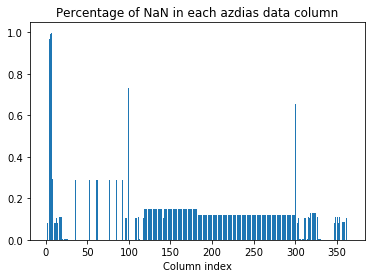

In [7]:
# Plot percentage of NaN in each column
plt.bar(np.arange(len(perc_nan)), perc_nan);
plt.title('Percentage of NaN in each azdias data column');
plt.xlabel('Column index');

**Check column data type**

In [6]:
# Count columns in numeric, boolean and category type
num_azd = azdias.select_dtypes(include=['int','float64']).columns
bool_azd = azdias.select_dtypes(include=['bool']).columns
cat_azd = azdias.select_dtypes(include=['object']).columns
len(num_azd), len(bool_azd), len(cat_azd)

(360, 0, 6)

In [9]:
# Check category columns
azdias.loc[:,cat_azd].head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W


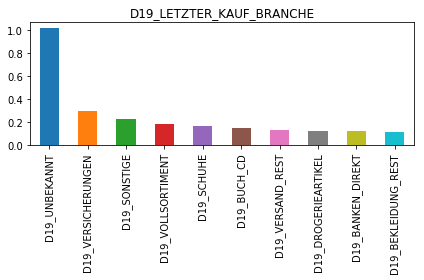

In [10]:
# Check column "D19_LETZTER_KAUF_BRANCHE" values
count_vals = azdias.D19_LETZTER_KAUF_BRANCHE.value_counts()
(count_vals[:10]/customers.shape[0]).plot(kind='bar');
plt.title('D19_LETZTER_KAUF_BRANCHE');
plt.tight_layout();

In [7]:
print('Numeric columns min value: {}'.format(azdias[num_azd].min().min()))
print('Numeric columns max value: {}'.format(azdias[num_azd].max().max()))

Numeric columns min value: -1.0
Numeric columns max value: 1082873.0


### <a class="anchor" id="part0.2">  0.2 Explore customers data </a>

**Check NaN values in the data**

In [8]:
# Check NaN values
perc_na = customers.isnull().mean()
print('Column No. with >90% NaN: ', np.where(perc_na>0.9))

Column No. with >90% NaN:  (array([4, 5, 6, 7]),)


customers data has the same four columns with more than 90% NaNs. These columns can be dropped when cleaning the data.

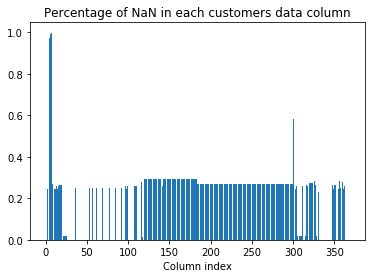

In [9]:
plt.bar(np.arange(len(perc_na)), perc_na);
plt.title('Percentage of NaN in each customers data column');
plt.xlabel('Column index');

**Check column data type**

In [10]:
num_cust = customers.select_dtypes(include=['int','float64']).columns
bool_cust = customers.select_dtypes(include=['bool']).columns
cat_cust = customers.select_dtypes(include=['object']).columns
num_cust.shape, bool_cust.shape, cat_cust.shape

((361,), (0,), (8,))

In [11]:
# Category columns
cat_cust

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

Customers data has three more columns than azdias data: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'. Let's check the value distribution of these columns.

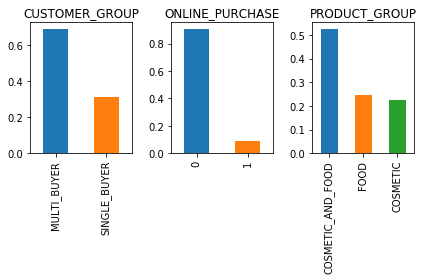

In [12]:
col_names = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
i=1
for col_name in col_names:
    plt.subplot(1,3,i)
    count_vals = customers[col_name].value_counts()

    (count_vals[:10]/customers.shape[0]).plot(kind='bar');
    plt.title(col_name);
    plt.tight_layout();
    i +=1

## <a class="anchor" id="part1"> Part 1: Customer Segmentation Report </a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### <a class="anchor" id="part1.1"> 1.1 Load and clean data </a>

After loading the data from csv file, column 8 and 9 need to be converted to numeric types first.

According to data exploraton in the previous section, there are four columns 'ALTER_KIND1','ALTER_KIND2','ALTER_KIND3' and 'ALTER_KIND4' with more than 90% of NaNs that can be dropped. There is one datetime column 'EINGEFUEGT_AM' which has no description in "DIAS Attributes - Values 2017.xlsx". This will also be dropped. 

Furthermore, according to feature descriptions in "DIAS Attributes - Values 2017.xlsx" I found most of the features in numeric columns have "unkown" category which is coded as -1, 0, or 9. Hence NaN in each column can be filled as the numeric code of "unkown" category. If the "unknow" category has more than 1 numeric code, they will be merge to 1 number.

Finally, category columns are encoded to numbers. All the steps will be performed in the "load_and_clean_data" function below.

In [106]:
def load_and_clean_data(file_name):
    '''
    INPUT
    file_name - csv file name
    
    OUTPUT 
    df - pandas dataframe 
    
    This function load data from csv file to df and cleans df by the following steps:
    1. Convert 2 columns from string to number
    2. Drop columns with 90% more NaNs, 1 ID column and 1 datetime column
    3. Fill NaNs in numeric columns with label of unknown
    4. Encode category columns to numeric columns
    
    '''
    # Load data from csv file
    types_dict = {'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015': object}
    df = pd.read_csv(file_name, sep=';', dtype=types_dict)
    print('File loaded...')
    print('data shape before cleaning: {}'.format(df.shape))
    
    # Convert two columns to numeric type
    df.CAMEO_DEUG_2015 = pd.to_numeric(df.CAMEO_DEUG_2015, errors='coerce')
    df.CAMEO_INTL_2015 = pd.to_numeric(df.CAMEO_INTL_2015, errors='coerce')

    # Drop columns with more than 90% of missing values 
    perc_nan = df.isnull().mean()
    df = df.drop(df.columns[np.where(perc_nan>0.9)], axis=1)
    # Drop one ID column and one datetime columns
    df = df.drop(['LNR','EINGEFUEGT_AM'], axis=1)
    
    # Map NaN to Unknown label 10 in the following columns
    col_unknown_10 = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                       'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM', 
                       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'];
    for col in col_unknown_10:
        df[col].fillna(10, inplace=True) 
 
    # Map NaN and -1 to Unknown label 0 in the following columns
    col_name0 = ['ALTERSKATEGORIE_GROB','ANREDE_KZ','GEBAEUDETYP','HH_EINKOMMEN_SCORE','KBA05_BAUMAX',
                 'KBA05_GBZ','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','REGIOTYP','TITEL_KZ',
                 'WOHNDAUER_2008','W_KEIT_KIND_HH','KKK']
    for col in col_name0:
        df[df[col]==-1] = 0
        df[col].fillna(0, inplace=True)
    
    # Map NaN and -1 to Unknown label 9 in the following columns
    indx00 = np.where(df.columns.str.match('KBA05_CCM1'))[0][0]
    indx01 = np.where(df.columns.str.match('KBA05_FRAU'))[0][0]+1                  
    indx10 = np.where(df.columns.str.match('KBA05_HERST1'))[0][0]
    indx11 = np.where(df.columns.str.match('KBA05_ZUL4'))[0][0]+1                                 
    indx20 = np.where(df.columns.str.match('SEMIO_DOM'))[0][0]
    indx21 = np.where(df.columns.str.match('SEMIO_VERT'))[0][0]+1
                  
    indx3 = np.where(df.columns.str.match('D19_KONSUMTYP'))[0][0]                 
    indx4 = np.where(df.columns.str.match('RELAT_AB'))[0][0]
    indx5 = np.where(df.columns.str.match('ZABEOTYP'))[0][0]
                 
    col_indx = np.concatenate((np.arange(indx00,indx01),np.arange(indx10,indx11),np.arange(indx20,indx21),
                               np.arange(indx3,indx3+1),np.arange(indx4,indx4+1),np.arange(indx5,indx5+1)))
    col_name9 = df.columns[col_indx]
    for col in col_name9:
        df[df[col]==-1] = 9
        df[col].fillna(9, inplace=True)
    
    # Replace NaN in the rest of numeric columns with min()
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].min()), inplace=True)  
    print('NaN in numeric columns filled...')
          
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        
    print('File cleaned.')
    print('data shape after cleaning: {}'.format(df.shape))
    
    return df

**Load and clean "azdias" and "customers" data**

In [4]:
azd = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv')
print('Cleaned azdias shape: {}'.format(azd.shape))

File loaded...
data shape before cleaning: (891221, 366)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (891221, 437)
Cleaned azdias shape: (891221, 437)


In [18]:
cust = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv')
print('Cleaned customers shape: {}'.format(cust.shape))

File loaded...
data shape before cleaning: (191652, 369)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (191652, 441)
Cleaned customers shape: (191652, 441)


### <a class="anchor" id="part1.2"> 1.2 Perform PCA to reduce features </a>

**Define fuction to standardize data and perform PCA**

In [12]:
def choose_principal_components(df, percent=0.9):
    '''
    INPUT 
    df - 2D pandas dataframe 
    percent - percentage of data variance to be perserved after pca
    
    OUTPUT
    df_principal - 2D dataframe of ordered principal components from df
    num_pca - minimum number of principal components that perserves more than "percent" of variance of df
    pca - PCA model
    
    This function perform PCA on df and return pca model, principal components in order and its number
    and plot accumulated percentage of variance explained by each of the principal components.
    
    '''
    # Standardize data for PCA
    df_std = StandardScaler().fit_transform(df)
    print('Standardized data...')
    
    # Perform PCA
    pca = PCA(n_components=df.shape[1]) 
    pca.fit(df_std) 
    print('Initial PCA is done...')
    
    # Accumulate percentage of variance explained by each of the principal components.
    weight_pca = pca.explained_variance_ratio_
    perc_pca = np.cumsum(weight_pca)
    # Minimum number of principal components that perserves more than 90% of variance of df
    num_pca = np.where(perc_pca>=percent)[0][0]
    
    # PCA transform df_std to num_pca components
    pca = PCA(n_components=num_pca) 
    principal_components = pca.fit_transform(df_std) 
    df_principal= pd.DataFrame(principal_components)
    print('Final PCA keeps {} features.'.format(num_pca))
    
    # Plot PCA results
    plt.figure(figsize=(6,4))
    plt.plot(perc_pca, color='k', lw=2)
    plt.xlabel('Number of components')
    plt.ylabel('Total explained variance')
    plt.xlim(0, df.shape[1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.axvline(num_pca, c='b')
    plt.axhline(percent, c='r')
    plt.show();
    
    return df_principal, num_pca, pca

**Choose minimum number of features to perserve 90% of data characterization**

Standardized data...
Initial PCA is done...
Final PCA keeps 196 features.


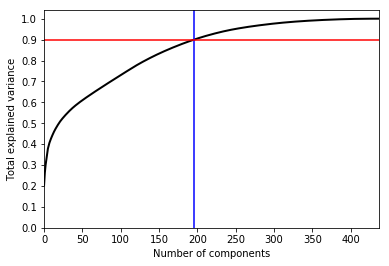

In [8]:
# Perform PCA on azdias
azdias_pca, num_pca, pca = choose_principal_components(azd, percent=0.9)

**Check feature importance in each principal component**

In [7]:
def create_importance_dataframe(pca, df_col):
    '''
    INPUT 
    pca - PCA model
    df_col - features(column names) of original dataframe
    
    OUTPUT
    importance_df - 2D dataframe of feature importance for each PCA component
    
    This function record feature importance for each PCA component into a 2D dataframe
    
    '''

    # Change pcs components ndarray to a dataframe
    importance_df  = pd.DataFrame(pca.components_)

    # Assign columns
    importance_df.columns  = df_col

    # Change to absolute values
    importance_df =importance_df.apply(np.abs)

    # Transpose
    importance_df=importance_df.transpose()

    # Change column names again

    ## First get number of pcs
    num_pcs = importance_df.shape[1]

    ## Generate the new column names
    new_columns = [f'PC{i}' for i in range(1, num_pcs + 1)]

    ## Now rename
    importance_df.columns  = new_columns

    # Return importance df
    return importance_df

The table below shows the importance score of each feature in each principal component.

In [24]:
# Call function to create importance df
importance_df  =create_importance_dataframe(pca, azd.columns)

# Show first few rows
display(importance_df.iloc[0:4,0:10])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,,,,,,,,,,
AGER_TYP,0.015606,0.020604,0.087173,0.111155,0.071086,0.022713,0.011390,0.012221,0.006517,0.007652
AKT_DAT_KL,0.020091,0.076269,0.015559,0.094828,0.019993,0.015017,0.008302,0.021950,0.026119,0.005972
ALTER_HH,0.036754,0.067253,0.080085,0.012134,0.002286,0.012953,0.003984,0.009618,0.054359,0.013933
ALTERSKATEGORIE_FEIN,0.036850,0.060609,0.094507,0.024257,0.008164,0.014275,0.001293,0.016360,0.038335,0.027822


Now we can plot the top 10 features in the first principal component.

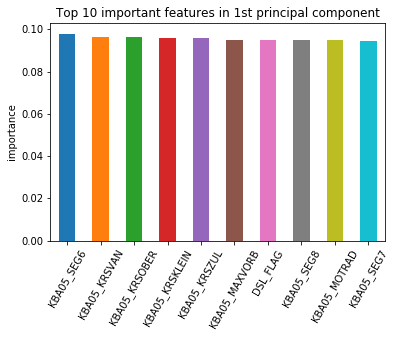

In [63]:
# Sort depending on PC of interest

## PC1 top 10 important features
pc1_top_10_features = importance_df['PC1'].sort_values(ascending = False)[:10]
# print(), print(f'PC1 top 10 feautres are \n')
# display(pc1_top_10_features )

# Plot top 10 important features in the first principal component
ax = pc1_top_10_features.plot.bar(title='Top 10 important features in 1st principal component',rot=60);
ax.set_ylabel('importance');

#### Perform the same PCA on customers data

In [32]:
# find columns to drop in customers data which are not in azdias data
col_drop = np.setdiff1d(cust.columns, azd.columns)
# Standardize customers data
cust_std = StandardScaler().fit_transform(cust.drop(col_drop,axis=1))
# Perform PCA on customers data as same as PCA on azdias data
customers_pca = pca.transform(cust_std)

In [33]:
customers_pca.shape

(191652, 196)

### <a class="anchor" id="part1.3"> 1.3 K-Means clustering </a>

**Choose a reasonable cluser number**

Run k-means to cluster the neighborhood into 2~20 clusters. Calculate the sum of squared distance to find the optimal cluster number.

In [39]:
def choose_kmean_number(df):
    '''
    INPUT 
    df - pandas dataframe 
    
    OUTPUT
    None
    
    This function display elbow plot for k-mean clustering on df
    
    '''
    Sum_of_squared_distances = []
    for k in range(2,20,2):
        # run k-means clustering
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        # Record sum of squared distances of samples to the nearest cluster center
        Sum_of_squared_distances.append(kmeans.inertia_)

    K = range(2,20,2)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k',fontsize=14)
    plt.ylabel('Sum_of_squared_distances',fontsize=14)
    plt.title('Elbow method for optimal k',fontsize=14)
    plt.show()

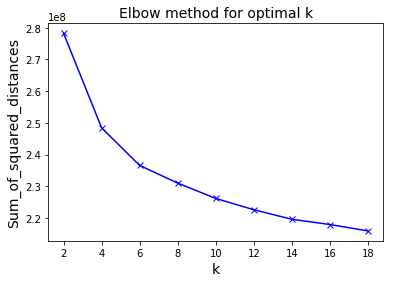

In [65]:
choose_kmean_number(azdias_pca)

According to the elbow plot, we can divide azdias data to 10 clusters.

#### Run k-means clusering for 10 clusters

In [11]:
def kmean_clustering(k, df_pca, df):
    '''
    INPUT 
    k - number of clustering
    df_pca - pandas dataframe with reduced features after PCA
    df - original pandas dataframe 
    
    OUTPUT
    df - original pandas dataframe with cluster label added to the first column
    kmeans - KMeans clustering model
    
    This function groups df_pca into k clusters and add cluster labels to the original df
    
    '''
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_pca)

    # add clustering labels to df
    df.insert(0, 'Cluster Label', kmeans.labels_)

    return df, kmeans

Clustering azdias

In [18]:
azdias, kmeans = kmean_clustering(10, azdias_pca, azd)
azdias.iloc[0:5,0:9]

,Cluster Label,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN
0,0,-1,1,0,0,0,0,0,0.0
1,1,-1,9,0,21,11,0,0,2.0
2,1,-1,9,17,17,10,0,0,1.0
3,5,2,1,13,13,1,0,0,0.0
4,7,-1,1,20,14,3,0,0,4.0


Do the same clustering on customers data

In [49]:
# Do the same KMeans clustering on customers data
cust_labels = kmeans.predict(customers_pca)
# add clustering labels to customers
cust.insert(0, 'Cluster Label', cust_labels)

#### Check clustering

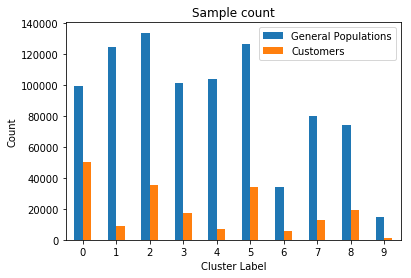

In [64]:
# Get sample count in each cluster
azd_cluster = azdias.groupby('Cluster Label').LNR.count()
cust_cluster = cust.groupby('Cluster Label').LNR.count()
# Plot sample count in each cluster
df_cluster = pd.concat([azd_cluster, cust_cluster], axis=1, sort=False)
df_cluster.columns = ['General Populations', 'Customers']
df_cluster.plot(kind="bar", title="Sample count",rot=0);
plt.ylabel("Count");

## <a class="anchor" id="part2"> Part 2: Supervised Learning Model </a>

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### <a class="anchor" id="part2.1"> 2.1 Load, clean and perform PCA on training data </a>

In [107]:
mailout_train = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv')

File loaded...
data shape before cleaning: (42962, 367)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (42962, 437)


In [109]:
X_train = mailout_train.drop('RESPONSE',axis=1)
Y_train = mailout_train['RESPONSE']

Standardized data...
Initial PCA is done...
Final PCA keeps 184 features.


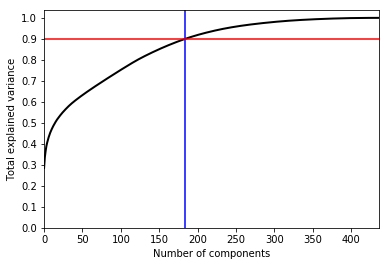

In [110]:
X_train_pca, num_pca, pca = choose_principal_components(X_train, 0.9)

### <a class="anchor" id="part2.2"> 2.2 Downsample training data on major class  </a>

In [111]:
def downsample_class0(X, Y, k_cluster=10, DnSamp_rate=20):
    '''
    INPUT
    X - 2D dataframe for down-sampling
    Y - 1D array of class labels(0/1) for X
    k_cluster - k-mean cluster number 
    DnSamp_rate - down-sampling rate
    
    OUTPUT
    X_DnSamp - 2D dataframe for down-sampled X
    Y_DnSample - 1D array of class labels(0/1) for X_DnSamp
    
    This function performs k-mean clustering on X, and down sample class 0 in each cluster
    
    '''
    # Run k_mean cluster for 10 cluster on class 0 of traning data
    X_class0 = X[Y==0]
    X_class1= X[Y==1]
    print('Original Class1/Class0 = {}'.format(sum(Y==1)/sum(Y==0)))

    X_class0_cluster, kmeans = kmean_clustering(k_cluster, X_class0, X_class0)
    print('K-mean clustering is done for {} clusters.'.format(k_cluster))

    # Down-sample in each cluster of class 0 
    cluster_size = X_class0_cluster.groupby('Cluster Label').count()[0]
    X_DnSamp = pd.DataFrame()
    for i in np.arange(k_cluster):
        df_cluster = X_class0_cluster[X_class0_cluster['Cluster Label']==i]
        X_DnSamp = X_DnSamp.append(df_cluster.sample(n=round(cluster_size[i]/DnSamp_rate).astype(int), 
                                                          random_state=i))

    # Append class 1 data
    X_DnSamp.drop('Cluster Label',axis=1,inplace=True)
    num_class0 = X_DnSamp.shape[0]
    X_DnSamp = X_DnSamp.append(X_class1)
    # Set same column names
    X_DnSamp.columns = X.columns
    print('Down sampled X size: {}'.format(X_DnSamp.shape))

    # Down sample Y_train
    Y_DnSample = np.zeros(X_DnSamp.shape[0], dtype=int)
    Y_DnSample[num_class0:] = 1
    print('Down sampled Class1/Class0 = {}'.format(sum(Y_DnSample==1)/sum(Y_DnSample==0)))

    return X_DnSamp, Y_DnSample

In [112]:
X_train_pca_DnSamp, Y_train_DnSample = downsample_class0(X_train_pca, Y_train, k_cluster=10, DnSamp_rate=100)

Original Class1/Class0 = 0.012538298373792129
K-mean clustering is done for 10 clusters.
Down sampled X size: (957, 184)
Down sampled Class1/Class0 = 1.251764705882353


### <a class="anchor" id="part2.3"> 2.3 classify training data </a>

In [113]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train_pca_DnSamp, Y_train_DnSample)
yhat = clf.predict(X_train_pca)
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
clf

ROC score: 0.6459315121411826


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [114]:
LR = LogisticRegression(C=0.02, solver='sag').fit(X_train_pca_DnSamp, Y_train_DnSample)
yhat = LR.predict(X_train_pca)
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
LR

ROC score: 0.6382666098430143


LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    INPUT
    cm - actual class in 1D array
    classes - predicted class in 1D array
    
    OUTPUT
    None
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  453    79]
 [24396 18034]]


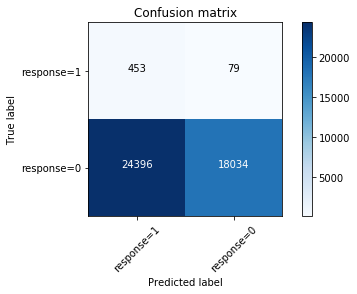

In [116]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_train, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','response=0'],normalize= False,  title='Confusion matrix')

In [117]:
xgbr = xgb.XGBClassifier(verbosity=0) 
print(xgbr)
# xgbr.fit(X_train_pca_DnSamp, Y_train_DnSample)
xgbr.fit(X_train_pca_DnSamp, Y_train_DnSample)
yhat = xgbr.predict(X_train_pca)
# roc score
roc = roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
# print("Training score: ", xgbr.score(X_train_pca, Y_train))
results = cross_val_score(xgbr, X_train_pca_DnSamp, Y_train_DnSample, cv=3)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=None, num_parallel_tree=None,
       objective='binary:logistic', random_state=None, reg_alpha=None,
       reg_lambda=None, scale_pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=0)
ROC score: 0.7067941625215525
Accuracy: 46.71% (3.04%)


Confusion matrix, without normalization
[[  497    35]
 [22090 20340]]


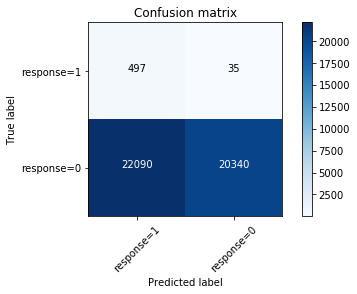

In [118]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_train, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','response=0'],normalize= False,  title='Confusion matrix')

In [119]:
print('Training   class1: {}, class0: {}, class1/class0: {}'.
      format(sum(Y_train==1),sum(Y_train==0),round(sum(Y_train==1)/sum(Y_train==0),2)))
print('Prediction class1: {}, class0: {}, class1/class0: {}'.
      format(sum(yhat==1),sum(yhat==0),round(sum(yhat==1)/sum(yhat==0),2)))
score_train = clf.score(X_train_pca, Y_train)
score_train

Training   class1: 532, class0: 42430, class1/class0: 0.01
Prediction class1: 22587, class0: 20375, class1/class0: 1.11


0.46378194683673946

### <a class="anchor" id="part2.4"> 2.4 Improve classifier on training data </a>

In [128]:
# Build pipeline
pipeline = Pipeline([
                ('xgbr', xgb.XGBClassifier(verbosity=0))
                ])
pipeline

Pipeline(memory=None,
     steps=[('xgbr', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_c..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=0))])

In [129]:
# Use GridSearchCV to optimize model
parameters = {
     'xgbr__learning_rate': [0.01, 0.1],
     'xgbr__n_estimators': [200, 500],
     'xgbr__gamma': [0.1, 1.0]
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=4)
model

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgbr', XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_c..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgbr__learning_rate': [0.01, 0.1], 'xgbr__n_estimators': [200, 500], 'xgbr__gamma': [0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [130]:
model.fit(X_train_pca_DnSamp, Y_train_DnSample)
print("\nBest Parameters:", model.best_params_)


Best Parameters: {'xgbr__gamma': 0.1, 'xgbr__learning_rate': 0.1, 'xgbr__n_estimators': 200}


In [136]:
results = cross_val_score(model, X_train_pca_DnSamp, Y_train_DnSample, cv=3)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 37.89% (8.71%)


In [131]:
yhat = model.predict(X_train_pca)
# roc score
roc=roc_auc_score(Y_train, yhat)
print('ROC score: {}'.format(roc))
yhat_prob = model.predict_proba(X_train_pca)
yhat_prob[0:2]

ROC score: 0.7007606956349157


array([[ 0.02,  0.98],
       [ 0.39,  0.61]], dtype=float32)

Confusion matrix, without normalization
[[  497    35]
 [22602 19828]]


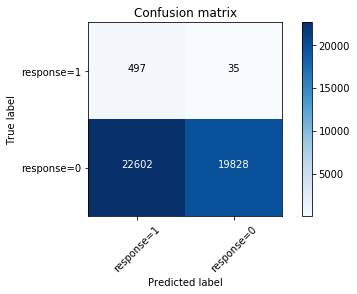

In [132]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_train, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','response=0'],normalize= False,  title='Confusion matrix')

In [67]:
print (classification_report(Y_train, yhat))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     42430
          1       0.42      0.88      0.57       532

avg / total       0.99      0.98      0.99     42962



### <a class="anchor" id="part3"> Part 3: Kaggle Competition </a>

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### <a class="anchor" id="part3.1"> 3.1 Prepare test data </a>

In [120]:
# Load and clean test data
mailout_test = load_and_clean_data('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv')

File loaded...
data shape before cleaning: (42833, 366)
NaN in numeric columns filled...
File cleaned.
data shape after cleaning: (42833, 436)


In [123]:
# Load 'LNR' column from original test data file
ID = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', usecols=['LNR'])

In [121]:
# Perform PCA on test data as same as PCA on training data
X_test_pca = pca.transform(mailout_test)
X_test_pca = pd.DataFrame(X_test_pca)

### <a class="anchor" id="part3.2"> 3.2 Predict test data </a>

In [133]:
# Predict on test data
y_test_est = model.predict_proba(X_test_pca)
# Save predic results to dataframe
df_predict['LNR'] = ID
df_predict['RESPONSE'] = y_test_est[:,1]

In [134]:
print('{}% in the test data has "RESPONSE"=1.'.format(round(100*sum(df_predict['RESPONSE']>=0.5)/df_predict.shape[0])))

1% in the test data has "RESPONSE"=1.


In [135]:
df_predict.to_csv('predict_test.csv', index=False, sep=',', encoding='utf-8')

In [138]:
# Save notebook to html format, return 0 if succeed
from subprocess import call
call(['python', '-m', 'nbconvert', 'Arvato Project Workbook.ipynb'])

0